## EXTRAÇÃO DE DADOS


In [ ]:
# Vamos trabalhar com pyspark, instalando:
!pip install pyspark

In [ ]:
# No meu caso já esta instalado, então para validar consulto assim:
import pyspark
print(pyspark.__version__)

3.5.5


In [ ]:
# Precisamos importar SparkSession
from pyspark.sql import SparkSession

In [ ]:
# Criando uma nova sessão
spark = SparkSession.builder.appName("jira_suporte").getOrCreate()

In [ ]:
# Chamando a sessão que criamos e lendo o arquivo csv; "show(5)" é para mostrar os 5 registros
spark.read.format('csv').option('header',True).load('sample_data/tickets_jira.csv').show(5)

+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+------------+------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+
|   TIPO_DE_ITEM|   CHAVE|              RESUMO|         CHAPTER|         RESPONSAVEL|             RELATOR|           CATEGORIA|PRIORIDADE|   STATUS|MOTIVO_DE_PENDENTE|  PLATAFORMA|  FREQUENCIA|RESOLUCAO|              CRIADO|        TIME_UPDATED|           RESOLVIDO|TEMPO_GASTO|INICIO_DESENVOLVIMENTO|FINAL_DESENVOLVIMENTO|
+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+------------+------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+
|Service request|TKT-1502|Ex

In [ ]:
# Salvando em um Data Frame
df = spark.read.format('csv').option('header',True).load('sample_data/tickets_jira.csv')

In [ ]:
# Mostrando o Data Frame apenas 5
df.show(5)

+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+------------+------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+
|   TIPO_DE_ITEM|   CHAVE|              RESUMO|         CHAPTER|         RESPONSAVEL|             RELATOR|           CATEGORIA|PRIORIDADE|   STATUS|MOTIVO_DE_PENDENTE|  PLATAFORMA|  FREQUENCIA|RESOLUCAO|              CRIADO|        TIME_UPDATED|           RESOLVIDO|TEMPO_GASTO|INICIO_DESENVOLVIMENTO|FINAL_DESENVOLVIMENTO|
+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+------------+------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+
|Service request|TKT-1502|Ex

## TRANSFORMAÇÃO DE DADOS

### DATA WRANGLING
"Refinando os dados": Etapa de (coleta, limpeza, transformação, enriquecimento, validação e exportação) estruturação e enriquecimento de dados brutos, para torná-los adequados para análise.

In [ ]:
#Importando as funções do Pyspark
from pyspark.sql.functions import to_timestamp

In [ ]:
# verirficando o tipo das colunas
df.printSchema()

In [ ]:
# Função de tratamento de data: Criando a coluna tipo DATA
df = df.withColumn('hora_inicio_dev',F.date_format(F.col('INICIO_DESENVOLVIMENTO'),"yyyy-MM-dd HH:mm:ss"))
df = df.withColumn('hora_final_dev',F.date_format(F.col('FINAL_DESENVOLVIMENTO'),"yyyy-MM-dd HH:mm:ss"))

In [ ]:
# Função de tratamento, convertendo a coluna STRING para timestamp
df = df.withColumn('hora_inicio_dev', to_timestamp("hora_inicio_dev", "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn('hora_final_dev', to_timestamp("hora_final_dev", "yyyy-MM-dd HH:mm:ss"))

In [ ]:
# Excluindo a coluna date do DataFrame
df = df.drop("tempo_gasto_formatado")

In [ ]:
# consultando apenas dados da consulta com data inicio e final do desenvolvimento que consta valores
df.where(
    (df["INICIO_DESENVOLVIMENTO"].isNotNull()) &
    (df["FINAL_DESENVOLVIMENTO"].isNotNull())
).show()

+---------------+--------+--------------------+---------+--------------------+--------------------+--------------------+----------+---------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+-------------------+-------------------+
|   TIPO_DE_ITEM|   CHAVE|              RESUMO|  CHAPTER|         RESPONSAVEL|             RELATOR|           CATEGORIA|PRIORIDADE|   STATUS|  MOTIVO_DE_PENDENTE|          PLATAFORMA|          FREQUENCIA|RESOLUCAO|              CRIADO|        TIME_UPDATED|           RESOLVIDO|TEMPO_GASTO|INICIO_DESENVOLVIMENTO|FINAL_DESENVOLVIMENTO|    hora_inicio_dev|     hora_final_dev|
+---------------+--------+--------------------+---------+--------------------+--------------------+--------------------+----------+---------+--------------------+--------------------+--------------------+---------+--------------------+---------------

In [ ]:
# consultando apenas pendente com desenvolvimento e sem resolução
df.where(
       (df["INICIO_DESENVOLVIMENTO"].isNotNull()) & (df["MOTIVO_DE_PENDENTE"] == "Com time de Desenvolvimento")
).show()

+---------------+--------+--------------------+---------+--------------------+--------------------+--------------------+----------+---------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+-------------------+-------------------+-------------------+---------------+
|   TIPO_DE_ITEM|   CHAVE|              RESUMO|  CHAPTER|         RESPONSAVEL|             RELATOR|           CATEGORIA|PRIORIDADE|   STATUS|  MOTIVO_DE_PENDENTE|          PLATAFORMA|          FREQUENCIA|    RESOLUCAO|              CRIADO|        TIME_UPDATED|           RESOLVIDO|TEMPO_GASTO|INICIO_DESENVOLVIMENTO|FINAL_DESENVOLVIMENTO|    hora_inicio_dev|     hora_final_dev|tempo_total_minutos|tempo_formatado|
+---------------+--------+--------------------+---------+--------------------+--------------------+--------------------+----------+---------+--------------------+--------

In [ ]:
df.show()

+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+---------------+--------------+-------------------+---------------+
|   TIPO_DE_ITEM|   CHAVE|              RESUMO|         CHAPTER|         RESPONSAVEL|             RELATOR|           CATEGORIA|PRIORIDADE|   STATUS|MOTIVO_DE_PENDENTE|          PLATAFORMA|          FREQUENCIA|RESOLUCAO|              CRIADO|        TIME_UPDATED|           RESOLVIDO|TEMPO_GASTO|INICIO_DESENVOLVIMENTO|FINAL_DESENVOLVIMENTO|hora_inicio_dev|hora_final_dev|tempo_total_minutos|tempo_formatado|
+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+-------------------

In [ ]:
# calculando em minutos o tempo de desenvolvimento
from pyspark.sql.functions import unix_timestamp, floor, concat, lit

df = df.withColumn("tempo_total_minutos",
                   (unix_timestamp("hora_final_dev") - unix_timestamp("hora_inicio_dev")) / 60)

In [ ]:
#  convertendo para horas e minitos, exemplo: 165 minutos seria 2h45min
from pyspark.sql import functions as F

df = df.withColumn(
    "tempo_formatado",
    F.concat(
        F.floor(F.col("tempo_total_minutos") / 60),  # Horas
        F.lit("h"),
        F.lpad(F.col("tempo_total_minutos") % 60, 2, "0"),  # Minutos
        F.lit("min")
    )
)


In [ ]:
#  convertendo para horas e minitos o campo em segundos
from pyspark.sql import functions as F

# Exemplo com 180 segundos
df = df.withColumn(
    "tempo_gasto_formatado",
    F.concat(
        F.floor(F.col("TEMPO_GASTO") / 3600),  # Horas
        F.lit(":"),
        F.lpad(F.floor((F.col("TEMPO_GASTO") % 3600) / 60), 2, "0")  # Minutos
    )
)


In [ ]:
df.show(5)

+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+------------+------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+---------------+--------------+-------------------+---------------+---------------------+
|   TIPO_DE_ITEM|   CHAVE|              RESUMO|         CHAPTER|         RESPONSAVEL|             RELATOR|           CATEGORIA|PRIORIDADE|   STATUS|MOTIVO_DE_PENDENTE|  PLATAFORMA|  FREQUENCIA|RESOLUCAO|              CRIADO|        TIME_UPDATED|           RESOLVIDO|TEMPO_GASTO|INICIO_DESENVOLVIMENTO|FINAL_DESENVOLVIMENTO|hora_inicio_dev|hora_final_dev|tempo_total_minutos|tempo_formatado|tempo_gasto_formatado|
+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+-------

In [ ]:
# Seleciona a coluna de temperatura, usa "F.mean" para pegar a media e coletando a informação; e faz o mesmo com Humidade
media_tipo = df.select(F.mean(F.col('TIPO_DE_ITEM'))).collect()[0][0]

print("Média de humidade -> ",media_tipo)

Média de humidade ->  None


In [ ]:
# Agrupar pelos tipos de item e contar a quantidade de registros (chamados)
df_count = df.groupBy("TIPO_DE_ITEM").count()

# Mostrar o resultado
df_count.show()


+---------------+-----+
|   TIPO_DE_ITEM|count|
+---------------+-----+
|       Incident|   35|
|Service request|  382|
+---------------+-----+



In [ ]:
# Agrupar pelos tipos de item Incident e contar a quantidade de registros (chamados)
df_count = df.groupBy("TIPO_DE_ITEM").count().where(F.col('TIPO_DE_ITEM') == "Incident")

# Mostrar o resultado
df_count.show()

+------------+-----+
|TIPO_DE_ITEM|count|
+------------+-----+
|    Incident|   35|
+------------+-----+



In [ ]:
# Agrupar por motivo da pendencia e contar a quantidade de registros (chamados)
df_list = df.groupBy("MOTIVO_DE_PENDENTE").count().where(F.col('MOTIVO_DE_PENDENTE').isNotNull())

# Mostrar o resultado
df_list.show()

+--------------------+-----+
|  MOTIVO_DE_PENDENTE|count|
+--------------------+-----+
|Aguardando aprovação|    2|
|Mais informações ...|   17|
|Com time de Desen...|    5|
|Pendente na solic...|    8|
+--------------------+-----+



In [ ]:
# Agrupar por Categoria e contar a quantidade de registros (chamados) ordenando por quantidade
df_order = df.groupBy("CATEGORIA").count().orderBy(F.col('count').desc())

# Mostrar o resultado
df_order.show()

+--------------------+-----+
|           CATEGORIA|count|
+--------------------+-----+
|Alteração de Stat...|   99|
|Alteração de Stat...|   41|
|Alterar FDA do pe...|   28|
|Alterar UnitId do...|   27|
|Problemas no vinc...|   25|
|Alteração Cadastr...|   24|
|Vinculação de Lin...|   21|
|Vincular Pedido -...|   18|
|Divergência de St...|   18|
|Falha integração ...|   16|
|Alterar Valor do ...|   15|
|Sem link de solic...|   12|
|Alteração de ID p...|   11|
|Cancelar link de ...|   10|
|              Outros|    9|
|   Problemas no site|    6|
|Desfazer recebime...|    6|
|Correção de Datas...|    6|
|Desvincular Pedid...|    5|
|Logística reversa...|    4|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Agrupar por RELATOR e contar a quantidade de registros (chamados) ordenando por quantidade
df_relator = df.groupBy("RELATOR").count().orderBy(F.col('count').desc())

# Mostrar o resultado
df_relator.show()

+--------------------+-----+
|             RELATOR|count|
+--------------------+-----+
|    Giovanna Felício|   30|
|Matheus de Olivei...|   24|
|       Gabriel Diniz|   23|
|              bianca|   23|
|Marcelo de Vilhen...|   17|
|Samuel Reis Farah...|   16|
|Brenda Gomes de S...|   16|
|        Brenda Souza|   15|
|Gabriel Robert Va...|   15|
|         Ana Miranda|   15|
|Fernanda Almeida ...|   15|
|     Samara Carneiro|   15|
|           Igor Muce|   14|
|   Ana Paula Azevedo|   14|
|Paulo Aranha Marques|   12|
|       Vitor Batista|   11|
|       bruna resende|   10|
|       Samuel Aranha|   10|
|Murilo Simoncini ...|    8|
|Andre Luiz Braz Reis|    8|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Listar os chamados com tipos de item = Incident
df.where(F.col('TIPO_DE_ITEM') == "Incident").show()

+------------+--------+--------------------+-----------+--------------------+--------------------+--------------------+----------+---------+--------------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+---------------+--------------+-------------------+---------------+---------------------+
|TIPO_DE_ITEM|   CHAVE|              RESUMO|    CHAPTER|         RESPONSAVEL|             RELATOR|           CATEGORIA|PRIORIDADE|   STATUS|  MOTIVO_DE_PENDENTE|          PLATAFORMA|          FREQUENCIA|RESOLUCAO|              CRIADO|        TIME_UPDATED|           RESOLVIDO|TEMPO_GASTO|INICIO_DESENVOLVIMENTO|FINAL_DESENVOLVIMENTO|hora_inicio_dev|hora_final_dev|tempo_total_minutos|tempo_formatado|tempo_gasto_formatado|
+------------+--------+--------------------+-----------+--------------------+--------------------+--------------------+----------+---------+--------------

#### Remoção de OUTLIERS

*   Será aceito o tempo  entre 0:10 e 0:39, tá OK, fora isso será um OUTLIERS
*   Item da lista



In [ ]:
# When equivalente ao "if" ; otherwise equivalente ao "else"
# Se tempo estiver entre 0:10 e 0:39, tá OK, usa o tempo, senão usa "maior""
# df = df.withColumn('tempo_gasto_formatado', F.when(F.col('tempo_gasto_formatado').between('0:10', '0:39'), F.col('tempo_gasto_formatado')).otherwise(F.lit("maior")))
# Não usei, pois não faz sentindo, foi apenas para praticar

In [ ]:
df.show(10)

+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+------------+------------+---------+--------------------+--------------------+--------------------+-----------+----------------------+---------------------+---------------+--------------+-------------------+---------------+---------------------+
|   TIPO_DE_ITEM|   CHAVE|              RESUMO|         CHAPTER|         RESPONSAVEL|             RELATOR|           CATEGORIA|PRIORIDADE|   STATUS|MOTIVO_DE_PENDENTE|  PLATAFORMA|  FREQUENCIA|RESOLUCAO|              CRIADO|        TIME_UPDATED|           RESOLVIDO|TEMPO_GASTO|INICIO_DESENVOLVIMENTO|FINAL_DESENVOLVIMENTO|hora_inicio_dev|hora_final_dev|tempo_total_minutos|tempo_formatado|tempo_gasto_formatado|
+---------------+--------+--------------------+----------------+--------------------+--------------------+--------------------+----------+---------+------------------+-------

In [ ]:
# salvando comprimindo gzip
df.write.option('compression','gzip').parquet('parquet_gzip_sensores.parquet')

In [ ]:
!pip install matplotlib seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

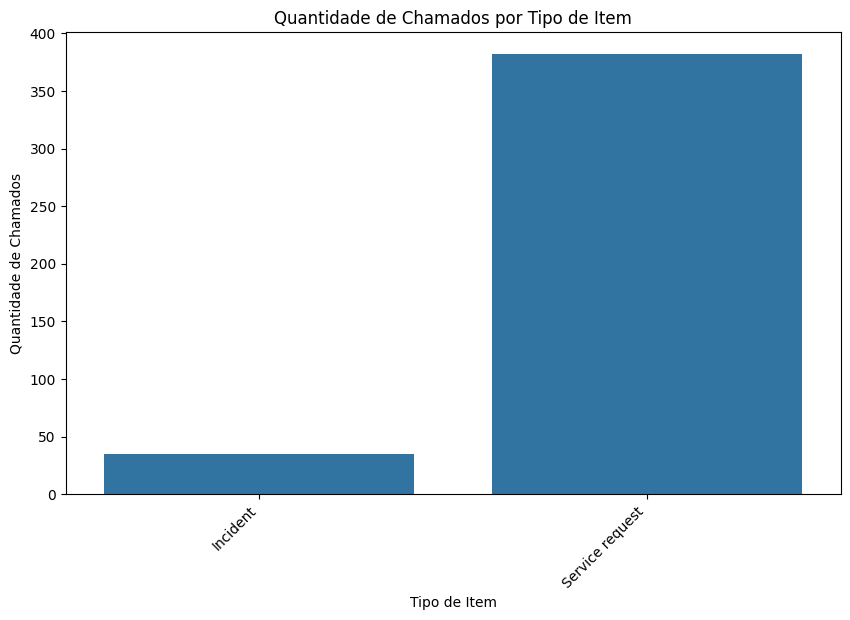

In [ ]:
df_count = df.groupBy("TIPO_DE_ITEM").count().toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="TIPO_DE_ITEM", y="count", data=df_count)
plt.title("Quantidade de Chamados por Tipo de Item")
plt.xlabel("Tipo de Item")
plt.ylabel("Quantidade de Chamados")
plt.xticks(rotation=45, ha="right")
plt.show()

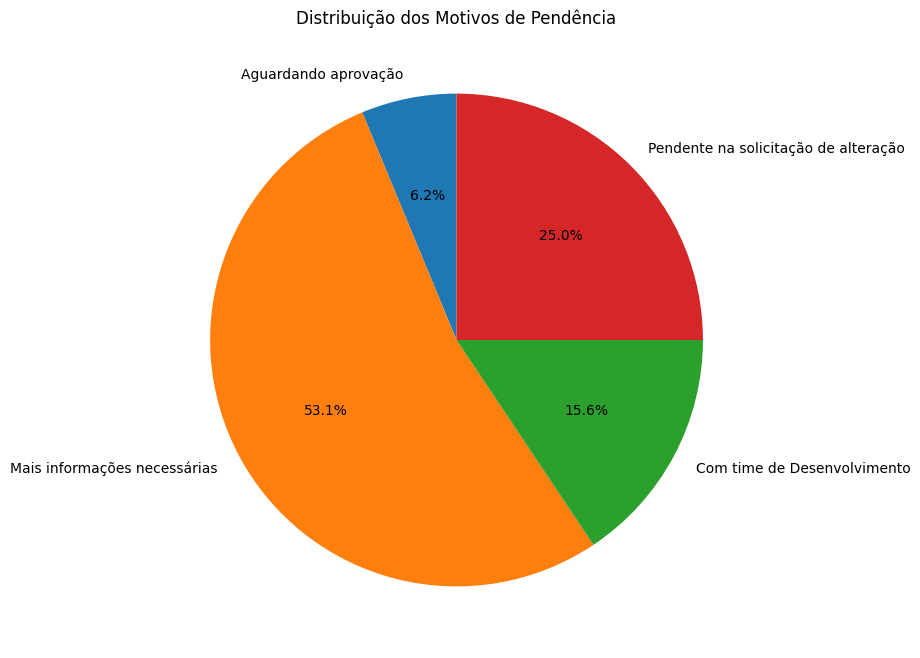

In [ ]:
df_list = df.groupBy("MOTIVO_DE_PENDENTE").count().where(F.col('MOTIVO_DE_PENDENTE').isNotNull()).toPandas()
plt.figure(figsize=(8, 8))
plt.pie(df_list["count"], labels=df_list["MOTIVO_DE_PENDENTE"], autopct="%1.1f%%", startangle=90)
plt.title("Distribuição dos Motivos de Pendência")
plt.show()

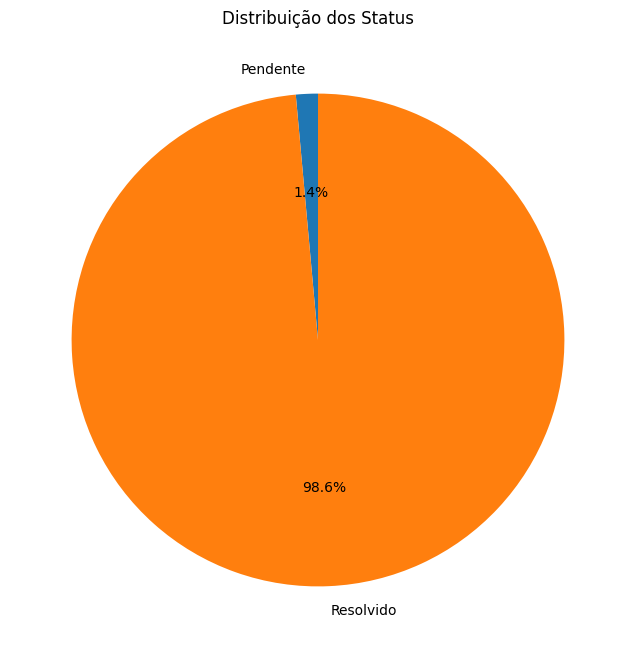

In [ ]:
df_list = df.groupBy("STATUS").count().where(F.col('STATUS').isNotNull()).toPandas()
plt.figure(figsize=(8, 8))
plt.pie(df_list["count"], labels=df_list["STATUS"], autopct="%1.1f%%", startangle=90)
plt.title("Distribuição dos Status")
plt.show()

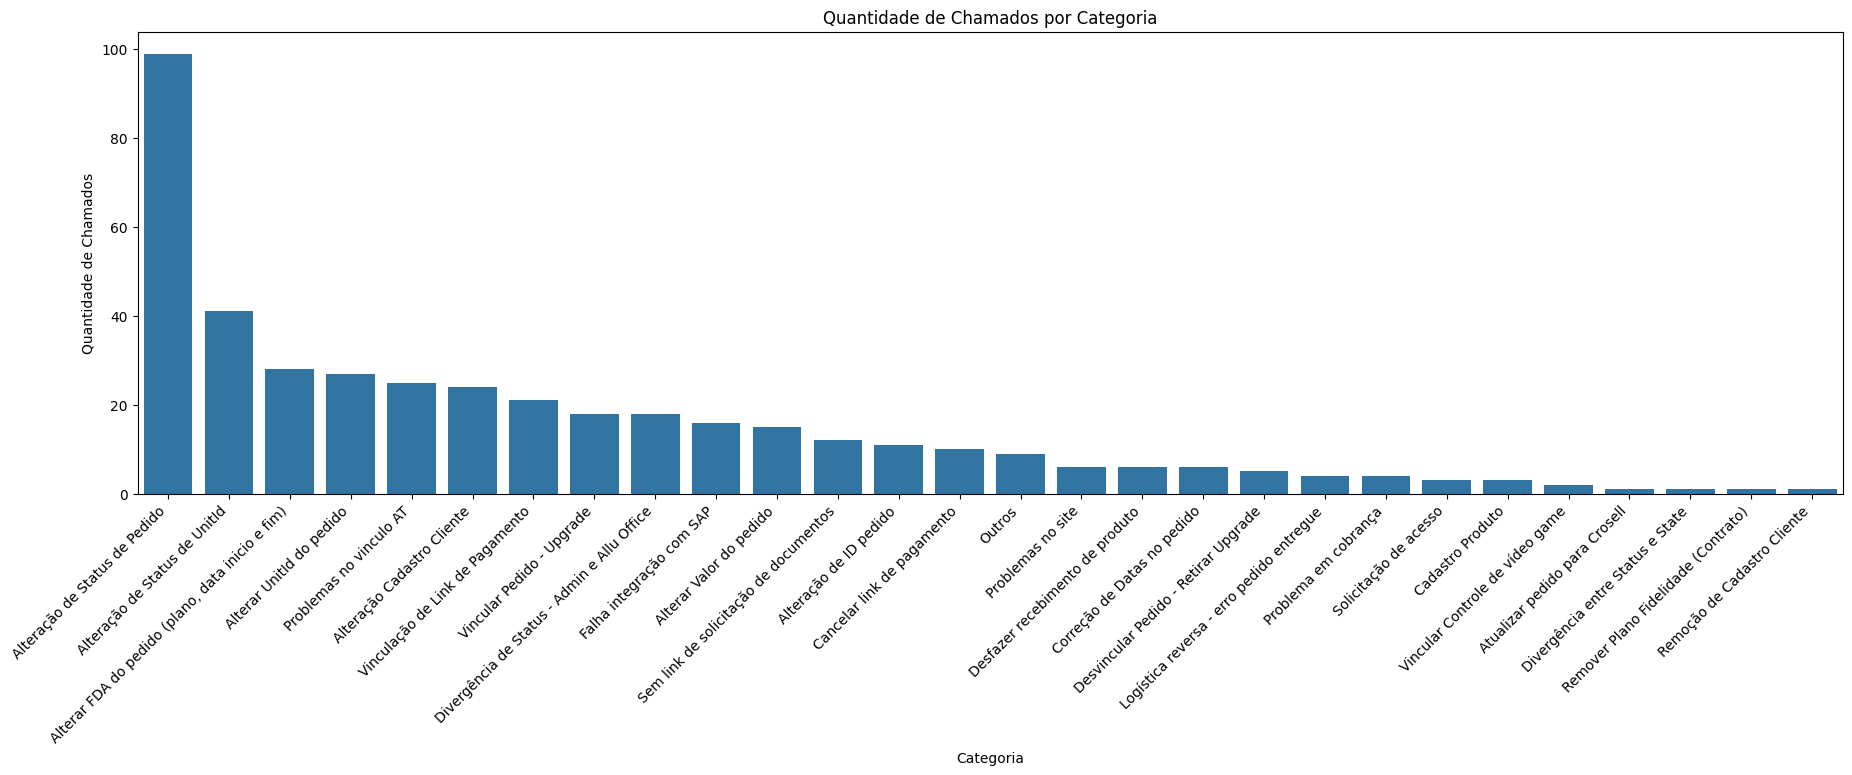

In [ ]:
df_order = df.groupBy("CATEGORIA").count().orderBy(F.col('count').desc()).toPandas()
plt.figure(figsize=(22, 6))
sns.barplot(x="CATEGORIA", y="count", data=df_order)
plt.title("Quantidade de Chamados por Categoria")
plt.xlabel("Categoria")
plt.ylabel("Quantidade de Chamados")
plt.xticks(rotation=45, ha="right")
plt.show()

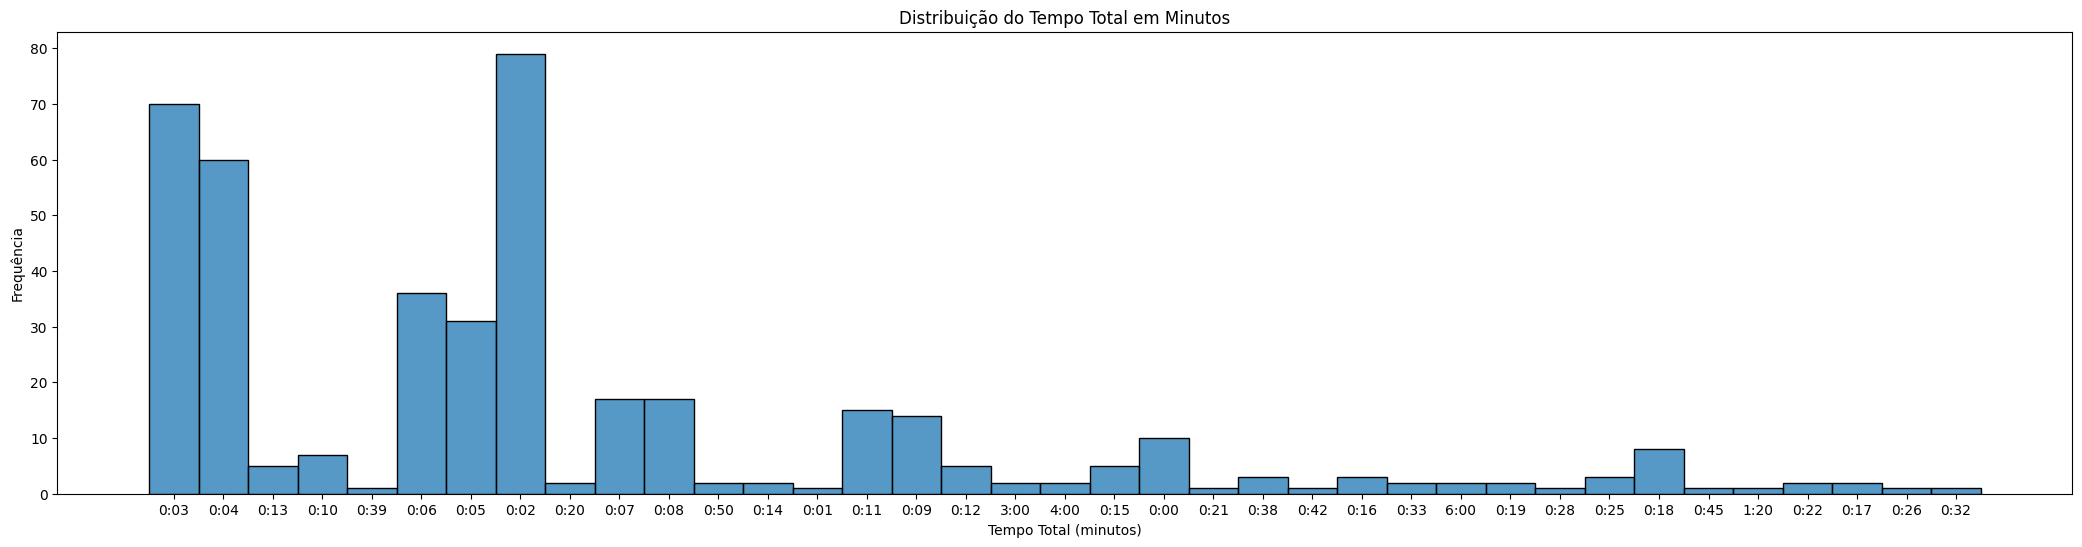

In [ ]:
df_tempo = df.select("tempo_gasto_formatado").toPandas()
plt.figure(figsize=(26, 6))
#sns.barplot(x="TIPO_DE_ITEM", y="count", data=df_count)
sns.histplot(df_tempo["tempo_gasto_formatado"], bins=20)
plt.title("Distribuição do Tempo Total em Minutos")
plt.xlabel("Tempo Total (minutos)")
plt.ylabel("Frequência")
plt.show()